# Double Deep Q Learning
> by Khizr Ali Pardhan | Alik604

[video](https://www.youtube.com/watch?v=RfNxXlO6BiA) | [Code](https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/DeepQLearning/torch_deep_q_model.py), [Code 2nd file](https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/DeepQLearning/main_torch_dqn_space_invaders.py) | [Code](https://github.com/BhavanJ/pytorch-spaceinvaders-/blob/master/Space_invaders_BJ.py) that I didnt use, but might be a good backup source

### done
* Steal some samplecode
    - why reimplement the wheel? 
* [skim a paper](http://cs231n.stanford.edu/reports/2016/pdfs/106_Report.pdf) to feel smart | Recurrent Deep Q-Learning for PAC-MAN

[source](https://medium.com/analytics-vidhya/introduction-to-double-deep-q-learning-ddqn-473833cf1a70) 




In Double Deep Q Learning, the agent uses two neural networks to learn and predict what action to take at every step. 

One network, referred to as the Q network or the online network, is used to predict what to do when the agent encounters a new state. 

It takes in the state as input and outputs Q values for the possible actions that could be taken. 

the online network takes **a few frames**, *i think*, (observation) and **outputs a vector of N Q values**, one for the value of moving left in the current state, and one for the value of moving right in the current state.

The agent will choose the action that has the higher corresponding Q value output by the online network. **like a argmax** 

Double DQNs handles the problem of the overestimation of Q-values.

The solution is: when we compute the Q target, we tend to use 2 networks to decouple the action selected from the target Q value generation. 

We:
* use our DQN network to select what is the best action required for the succeeding state (the action with the very best Q value).
* use our target network to calculate the target Q value of taking that action at the next state.
* Deep Q Network — selecting the best action a with maximum Q-value of next state.
* Target Network — calculating the estimated Q-value with action a selected above.

Therefore, Double Deep Q Network helps us reduce the overestimation of Q values and helps us train quicker and have more steady learning.

### Note

I used a unfrozen pretrained `mobilenet_v2`. Its slow :(

This change is reversable, you just have to swap-comment some lines

Be sure to change `agent.EPSILON` to `agent.EPS_END`, the latter is by default 0.05

To make Parallel
https://www.reddit.com/r/MachineLearning/comments/8aimei/d_what_is_the_right_way_to_parallelize_rollouts/
https://twitter.com/brandondamos/status/982699290492571654

In [3]:
import utils 
import time 
import pickle

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

import gym
from gym import wrappers

In [4]:
# from https://raw.githubusercontent.com/philtabor/Youtube-Code-Repository/master/ReinforcementLearning/DeepQLearning/torch_deep_q_model.py  
# video https://www.youtube.com/watch?v=RfNxXlO6BiA
class DeepQNetwork(nn.Module):
    def __init__(self, ALPHA):
        super(DeepQNetwork, self).__init__()
#         #self.conv1 = nn.Conv2d(3, 32, 8, stride=4, padding=1)
#         self.conv1 = nn.Conv2d(1, 64, 8, stride=4, padding=1)
#         self.conv2 = nn.Conv2d(64, 128, 4, stride=2)
#         self.conv3 = nn.Conv2d(128, 256, 3)
#         #self.fc1 = nn.Linear(128*23*16, 512)
#         self.fc1 = nn.Linear(256*19*8, 512)
#         self.fc2 = nn.Linear(512, 6)
#         #self.optimizer = optim.SGD(self.parameters(), lr=self.ALPHA, momentum=0.9)



        import torchvision.models as models
        mobilenet = models.mobilenet_v2(pretrained=True)
        
        # features is Sequence object, it is full of Conv and related layers. We don't touch that
        # classifier is Sequence object with a nn.Dropout object at the first index
        # and a nn.Linear object at the second/last index
        num_ftrs = mobilenet.classifier[-1].in_features
        # replace nn.Linear
        mobilenet.classifier[-1] = nn.Linear(num_ftrs, 6)

#         t_in = T.randn(64, 3, 256, 256)
#         print("MobileNet v2:", mobilenet.classifier, mobilenet(t_in).shape, sep="\n", end="\n\n")



        self.mobilenet = mobilenet
        self.optimizer = optim.RMSprop(self.parameters(), lr=ALPHA)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        print(f'Device: {self.device}')

    def forward(self, observation):
        observation = T.Tensor(observation).to(self.device)
        #observation = observation.view(-1, 3, 210, 160) #.to(self.device)
        observation = observation.view(-1, 3, 185, 95)
        return self.mobilenet(observation)
#         observation = observation.view(-1, 1, 185, 95)
#         observation = F.relu(self.conv1(observation))
#         observation = F.relu(self.conv2(observation))
#         observation = F.relu(self.conv3(observation))
#         #observation = observation.view(-1, 128*23*16).to(self.device)
#         observation = observation.view(-1, 256*19*8)
#         observation = F.relu(self.fc1(observation))
#         actions = self.fc2(observation)
#        return actions

In [5]:
class Agent(object):
    def __init__(self, gamma, epsilon, alpha,
                 maxMemorySize, epsEnd=0.05,
                 replace=10000, actionSpace=[0,1,2,3,4,5]):
        self.GAMMA = gamma
        self.EPSILON = epsilon
        self.EPS_END = epsEnd
        self.ALPHA = alpha
        self.actionSpace = actionSpace
        self.memSize = maxMemorySize
        self.steps = 0
        self.learn_step_counter = 0
        self.memory = []
        self.memCntr = 0
        self.replace_target_cnt = replace
        self.Q_eval = DeepQNetwork(alpha)
        self.Q_next = DeepQNetwork(alpha)

    def storeTransition(self, state, action, reward, state_):
        if self.memCntr < self.memSize:
            self.memory.append([state, action, reward, state_])
        else:
            self.memory[self.memCntr%self.memSize] = [state, action, reward, state_]
        self.memCntr += 1

    def chooseAction(self, observation):
        rand = np.random.random()
        actions = self.Q_eval.forward(observation)
        if rand < 1 - self.EPSILON:
            action = T.argmax(actions[1]).item()
        else:
            action = np.random.choice(self.actionSpace)
        self.steps += 1
        return action

    def learn(self, batch_size):
        self.Q_eval.optimizer.zero_grad()
        if self.replace_target_cnt is not None and \
           self.learn_step_counter % self.replace_target_cnt == 0:
            self.Q_next.load_state_dict(self.Q_eval.state_dict())

        if self.memCntr+batch_size < self.memSize:
            memStart = int(np.random.choice(range(self.memCntr)))
        else:
            memStart = int(np.random.choice(range(self.memSize-batch_size-1)))
        miniBatch=self.memory[memStart:memStart+batch_size]
        memory = np.array(miniBatch)

        # convert to list because memory is an array of numpy objects
#         print(memory[:,0][:] == memory[:,0])

        rewards = T.Tensor(list(memory[:,2])).to(self.Q_eval.device)
        indices = np.arange(batch_size)
        
        # I can double train the below, if i send `memory` all at once
        
        Qnext = self.Q_next.forward(list(memory[:,3][:])).to(self.Q_eval.device)
        maxA = T.argmax(Qnext, dim=1).to(self.Q_eval.device)      
        
        Qpred = self.Q_eval.forward(list(memory[:,0][:])).to(self.Q_eval.device)
        Qtarget = Qpred.clone()        
        Qtarget[indices,maxA] = rewards + self.GAMMA*T.max(Qnext[1])

        #Qpred.requires_grad_()
        loss = self.Q_eval.loss(Qtarget, Qpred).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        self.learn_step_counter += 1
        
        
        if self.steps > 500:
            if self.EPSILON - 1e-4 > self.EPS_END:
                self.EPSILON -= 1e-4
            else:
                self.EPSILON = self.EPS_END        
        
        
            
#if self.iter_cntr % self.replace_target == 0:
#    self.Q_next.load_state_dict(self.Q_eval.state_dict())
                

# This isn't my code. IDK why we dont optimize Q_next, however, I trust the author (youtube: machine learning with Phil). 
# This was because the two networks are different... IDK how to update the Q_next network

In [6]:
# env = gym.make('CarRacing-v0')
# env= gym.make('Pong-v0')
env = gym.make('SpaceInvaders-v0')

print(env.action_space.n)
print(env.observation_space)
# print(env.unwrapped.get_action_meanings())
# help(env.unwrapped)

env.reset().shape

6
Box(0, 255, (210, 160, 3), uint8)


(210, 160, 3)

In [32]:
start = time.time() # i7 4790k & RTX 3070, 70mins 
time.sleep(3)

env = gym.make('SpaceInvaders-v0')
agent = Agent(gamma=0.95, epsilon=1.0*1.0, 
              alpha=0.003, maxMemorySize=5000,
              replace=None)
while agent.memCntr < agent.memSize:
    observation = env.reset()
    done = False
    while not done:
        # 0 no action, 1 fire, 2 move right, 3 move left, 4 move right fire, 5 move left fire
        action = env.action_space.sample()
        observation_, reward, done, info = env.step(action)
        if done and info['ale.lives'] == 0:
            reward = -100
#         agent.storeTransition(np.mean(observation[15:200,30:125], axis=2), action, reward,
#                             np.mean(observation_[15:200,30:125], axis=2))
        agent.storeTransition(observation[15:200,30:125], action, reward,
                            observation_[15:200,30:125])
        observation = observation_
print('done initializing memory')

best_score = 200 # yes, this is weird
scores = []
epsHistory = []
numGames = 6
batch_size=25 # 32
# uncomment the line below to record every episode.
# env = wrappers.Monitor(env, "tmp/space-invaders-1", video_callable=lambda episode_id: True, force=True)
for i in range(numGames):
    print('starting game ', i+1, 'epsilon: %.4f' % agent.EPSILON)
    epsHistory.append(agent.EPSILON)
    done = False
    observation = env.reset()
    frames = [observation[15:200, 30:125]] #[np.sum(observation[15:200, 30:125], axis=2)]
    score = 0
    lastAction = 0
    while not done:
        if len(frames) == 3:
            action = agent.chooseAction(frames)
            frames = []
        else:
            action = lastAction
        observation_, reward, done, info = env.step(action)
        score += reward
#         frames.append(np.sum(observation_[15:200, 30:125], axis=2))
        frames.append(observation_[15:200, 30:125])

        if done and info['ale.lives'] == 0:
            reward = -100
#         agent.storeTransition(np.mean(observation[15:200, 30:125], axis=2), action, reward,
#                               np.mean(observation_[15:200, 30:125], axis=2))
        agent.storeTransition(observation[15:200, 30:125], action, reward,
                              observation_[15:200, 30:125])
        observation = observation_
        agent.learn(batch_size)
        lastAction = action
        #env.render()
        
    scores.append(score)
    print('score:',score)
    if score > best_score:
        best_score = score
        pickle.dump(agent, open(f'checkpoint_top_score{score}.p', "wb" ))   
        
x = [i+1 for i in range(numGames)]
fileName = f'{str(numGames)} Games Gamma {str(agent.GAMMA)} Alpha {str(agent.ALPHA)} Memory {str(agent.memSize)}.png'


end = time.time()
print(f'Time taken: {(end - start):.4f}')


## Batch since 32. cart pole. eps_dec=5e-4*1.5
# 31, 35 sec for CUDA, 80 steps.                             max 10-moving-average, 204

Device: cuda:0
Device: cuda:0
done initializing memory
starting game  1 epsilon: 1.5000


C:\Users\kali\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


score: 75.0
starting game  2 epsilon: 1.5000
score: 150.0
starting game  3 epsilon: 1.5000
score: 195.0
starting game  4 epsilon: 1.4397
score: 195.0
starting game  5 epsilon: 1.3366
score: 35.0
starting game  6 epsilon: 1.2869
score: 60.0
Time taken: 4570.4892


In [9]:
# utils.plotLearning(np.arange(len(scores)), scores[:], epsHistory, fileName)
def bench(N=1):
    for i in range(N):
        done = False
        score=0
        observation = env.reset()
        while not done:

            done = False
            observation = env.reset()
            frames = [observation[15:200,30:125]]
            score = 0
            lastAction = 0
            while not done:
                if len(frames) == 3:
                    action = agent.chooseAction(frames)
                    frames = []
                else:
                    action = lastAction
                observation_, reward, done, info = env.step(action)
                score += reward
                frames.append(observation_[15:200,30:125])
                if done and info['ale.lives'] == 0:
                    reward = -100
        #         agent.storeTransition(np.mean(observation[15:200,30:125], axis=2), action, reward,
        #                               np.mean(observation_[15:200,30:125], axis=2))
                observation = observation_
        #         agent.learn(batch_size)
                lastAction = action
                env.render()
        env.close()
        print(f'Score is:{score}')
bench(N=1)

Score is:105.0


In [ ]:
def train_more(n_games=50):
    for i in range(n_games):
        print('starting game ', i+1, 'epsilon: %.4f' % agent.EPSILON)
        epsHistory.append(agent.EPSILON)
        done = False
        observation = env.reset()
        frames = [observation[15:200, 30:125]] #[np.sum(observation[15:200, 30:125], axis=2)]
        score = 0
        lastAction = 0
        while not done:
            if len(frames) == 3:
                action = agent.chooseAction(frames)
                frames = []
            else:
                action = lastAction
            observation_, reward, done, info = env.step(action)
            score += reward
            frames.append(observation_[15:200, 30:125])

            if done and info['ale.lives'] == 0:
                reward = -100

            agent.storeTransition(observation[15:200, 30:125], action, reward,
                                  observation_[15:200, 30:125])
            observation = observation_
            agent.learn(32)
            lastAction = action

        scores.append(score)
        print('score:', score)
 
    pickle.dump(agent, open(f'checkpoint_sapaceInvaders_mobilenet_top_score_{score}_epoch{len(scores)}.p', "wb" ))   
            
train_more(n_games=6)

In [7]:
import pickle
# pickle.dump(agent, open(f'checkpoint_top_score_{scores[-1]}.p', "wb" ))

# agent = pickle.load(open("checkpoint_sapaceInvaders_mobilenet_top_score_130.0_epoch35.p",'rb'))

In [8]:
agent.EPSILON = 0.0 # 0.2 #0.75
agent.EPSILON

0.0

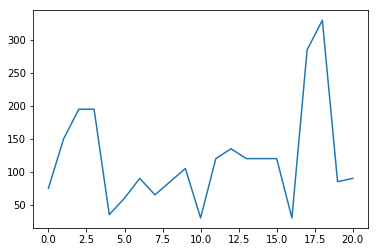

In [89]:
plt.plot(scores)

In [108]:
env.close()

In [33]:
pickle.dump(agent, open(f'checkpoint_spaceInvader_mobilenet_foobar.p', "wb" ))  